## 1.3 Formulation and statistical testing of hypotheses about the data

In [231]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower

### Dataset information 

In [232]:
dataset_path = r"..\data"

In [233]:
observation_file_name = "observation.csv"
patient_file_name = "patient.csv"
station_file_name = "station.csv"

#### Load dataset

In [234]:
observation = pd.read_csv(dataset_path + '/' + observation_file_name, sep='\t')
patient = pd.read_csv(dataset_path + '/' + patient_file_name, sep='\t')
station = pd.read_csv(dataset_path + '/' + station_file_name, sep='\t')

(A-4b) Formulate two hypotheses about the data in the context of the given prediction problem.   
Test the formulated hypotheses with appropriately chosen statistical tests. 

Hypotheses will formulate on the basis of the analyses made in the previous parts. 

- 1) Hb level has, on average, a higher value with oximetry than without it.
- 2) PRV has, on average, a higher value with oximetry than without it.

In [235]:
observation["oximetry"].unique()

array([0., 1.])

In [236]:
observation["oximetry"].value_counts()

oximetry
1.0    7183
0.0    4905
Name: count, dtype: int64

In [237]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]

---

### 1) Hb level has, on average, a higher value with oximetry than without it.

**$H_0$ (null hypothesis)**: The Hb level with oximetry is **the same** on average as the Hb level without oximetry.

**$H_1 = H_A$ (alternative hypothesis)**: The Hb level with oximetry is **greater** on average compared to the Hb level without oximetry.

<Axes: xlabel='oximetry', ylabel='Hb level'>

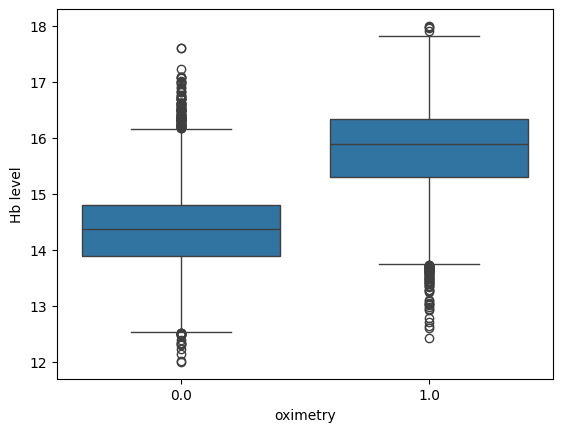

In [238]:
sns.boxplot(x='oximetry', y='Hb level', data=observation)

We can see that the oximetry value is in the range 0 or 1. From the boxplot visualization, it's clear that there is a relationship between the number of Hb level and oximetry.

In the previous part 1 we check if there is a correlation between these two attributes. Which showed a large positive correlation. This is the part where we measure differences between the means of the groups

We check the normality of the distribution:

In [239]:
hb_level0 = observation.loc[observation["oximetry"] == 0, "Hb level"]
hb_level1 = observation.loc[observation["oximetry"] == 1, "Hb level"]

In [240]:
hb_level0.describe()

count    4905.000000
mean       14.381550
std         0.746150
min        12.000000
25%        13.892513
50%        14.374953
75%        14.802705
max        17.601045
Name: Hb level, dtype: float64

In [241]:
hb_level1.describe()

count    7183.000000
mean       15.781054
std         0.808646
min        12.420627
25%        15.295760
50%        15.898910
75%        16.341527
max        18.000000
Name: Hb level, dtype: float64

<Axes: xlabel='Hb level', ylabel='Count'>

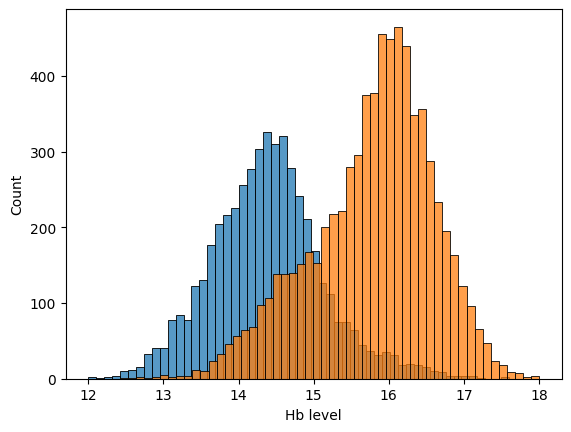

In [242]:
sns.histplot(hb_level0)
sns.histplot(hb_level1)

In [243]:
hb_level0_out = identify_outliers(hb_level0)
hb_level0_out

219      16.237813
363      16.630479
484      16.295432
497      16.321144
648      16.339836
           ...    
11351    16.311138
11356    16.815499
11367    16.191633
11500    17.085962
12012    12.000000
Name: Hb level, Length: 117, dtype: float64

In [244]:
hb_level1_out = identify_outliers(hb_level1)
hb_level1_out

493      13.545853
501      13.601151
514      13.056261
529      13.486235
979      13.635297
           ...    
11024    13.445445
11045    13.391271
11069    13.597999
11229    13.673857
11910    13.692576
Name: Hb level, Length: 75, dtype: float64

In [245]:
hb_level0 = hb_level0.drop(hb_level0_out.index)
hb_level1 = hb_level1.drop(hb_level1_out.index)

<Axes: xlabel='Hb level', ylabel='Count'>

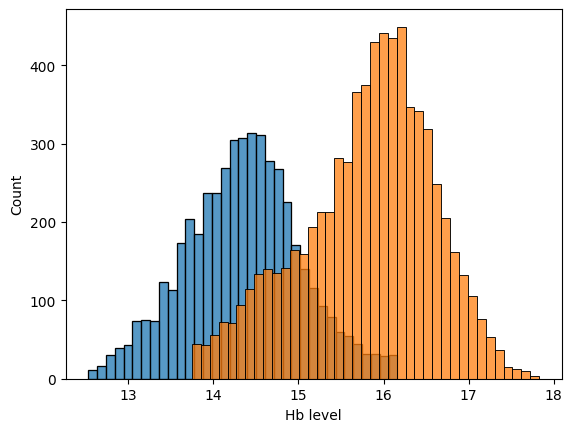

In [246]:
sns.histplot(hb_level0)
sns.histplot(hb_level1)

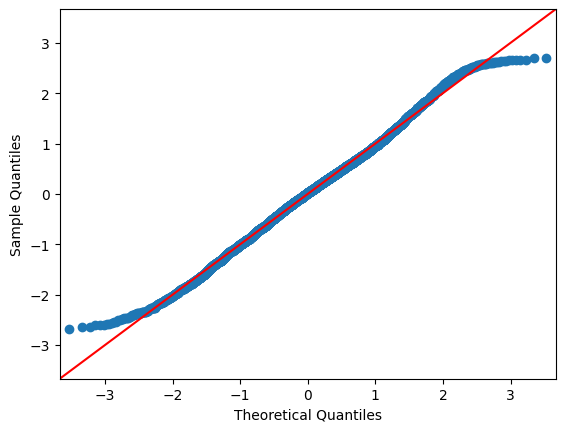

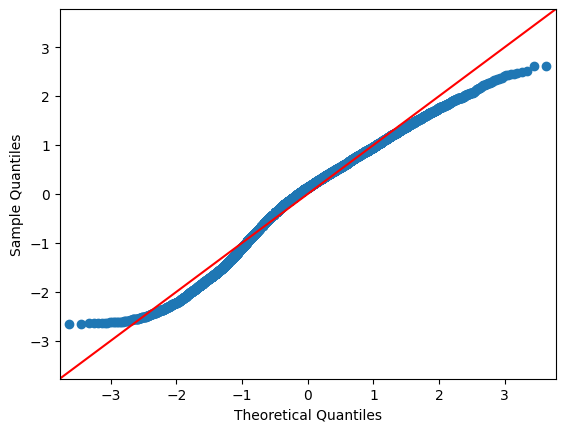

In [247]:
_ = sm.ProbPlot(hb_level0, fit=True).qqplot(line='45')
_ = sm.ProbPlot(hb_level1, fit=True).qqplot(line='45')

A QQ-plot is a visual method for determining whether two data sets come from the same distribution.

 **Issue with the Shapiro-Wilk's test: when you feed it more data, 
the chances of the H0
 being rejected becomes larger.**

To verify normality, we use the **Shapiro-Wilk test**, which tests the null hypothesis

In [248]:
stats.shapiro(hb_level0)

ShapiroResult(statistic=np.float64(0.9968820648087883), pvalue=np.float64(2.0046127806325378e-08))

In [249]:
stats.shapiro(hb_level1)

c:\Users\Andrii\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7108.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=np.float64(0.9813066691741245), pvalue=np.float64(1.4055256108640734e-29))

From the definition of **Shapiro-Wilk test** taken from the previous homework assignment, it follows: 

If $p < 0.05$, we reject the null hypothesis $H_0$ and the data probably come from a non-normal distribution.    
If $p > 0.05$, we do not reject the null hypothesis $H_0$, that is, based on the data, we cannot declare that the data come from a different than normal distribution.

Here's that means, we reject the null hypothesis $H_0$, as the values in both cases are less than 0.05. 


But **Kolmogorov–Smirnov test** test shows diferent results

In [250]:
stats.kstest(hb_level0, 'norm', args=(np.mean(hb_level0), np.std(hb_level0, ddof=1)))

KstestResult(statistic=np.float64(0.016436136270610135), pvalue=np.float64(0.1487956417938946), statistic_location=np.float64(14.87483964121667), statistic_sign=np.int8(1))

In [251]:
stats.kstest(hb_level1, 'norm', args=(np.mean(hb_level1), np.std(hb_level1, ddof=1)))

KstestResult(statistic=np.float64(0.059685473233864084), pvalue=np.float64(1.8760248114025133e-22), statistic_location=np.float64(15.77937580058438), statistic_sign=np.int8(-1))

Here we don't reject the null hypothesis $H_0$. The distribution of hb_level0 can be considered close to normal. hb_level1 distribution is not normal.

In [252]:
print(stats.anderson(Hb_level0, dist='norm'))
print(stats.anderson(Hb_level1, dist='norm'))

AndersonResult(statistic=np.float64(15.100719694286454), critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(113.98917965242947), scale=np.float64(20.82874484473617))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=np.float64(0.9027985897146209), critical_values=array([0.576, 0.656, 0.787, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(108.34510876977397), scale=np.float64(25.276346580724486))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


According to the **Anderson-Darling** test, **H0** was rejected for both groups. 

**Mann-Whitney U Test**

In [253]:
stats.mannwhitneyu(hb_level1, hb_level0, alternative='greater')

MannwhitneyuResult(statistic=np.float64(31057832.0), pvalue=np.float64(0.0))

Since p < 0 we reject **H0** and conclude that hb_level1 and hb_level0 differ statistically significantly.

In [254]:
stats.ttest_ind(hb_level1, hb_level0, equal_var=False, alternative='greater')

TtestResult(statistic=np.float64(108.72483056657875), pvalue=np.float64(0.0), df=np.float64(11144.255778211327))

**Welch's t-test** confirms the same result... We reject the null hepotise **H0** and conclude that Hb level has, on average, a higher value with oximetry than without it.

---

### 2) PRV has, on average, a higher value with oximetry than without it.

**$H_0$ (null hypothesis)**: The PRV with oximetry is **the same** on average as the PRV without oximetry.

**$H_1 = H_A$ (alternative hypothesis)**: The PRV with oximetry is **greater** on average compared to the PRV without oximetry.

<Axes: xlabel='oximetry', ylabel='PRV'>

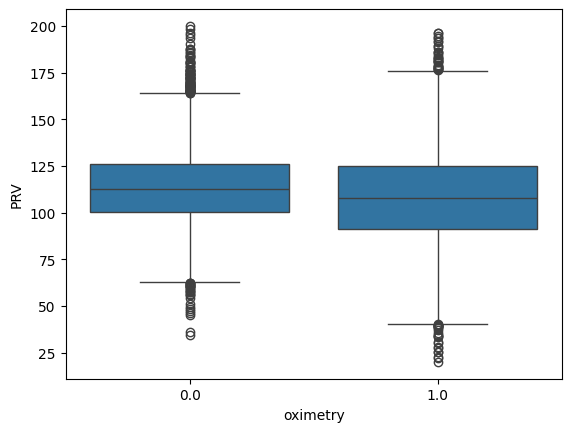

In [255]:
sns.boxplot(x='oximetry', y='PRV', data=observation)

In [256]:
prv0 = observation.loc[observation["oximetry"] == 0, "PRV"]
prv1 = observation.loc[observation["oximetry"] == 1, "PRV"]

In [257]:
prv0.describe()

count    4905.000000
mean      113.989180
std        20.828745
min        34.419111
25%       100.561157
50%       112.582502
75%       126.030866
max       200.000000
Name: PRV, dtype: float64

In [258]:
prv1.describe()

count    7183.000000
mean      108.345109
std        25.276347
min        20.000000
25%        91.185423
50%       107.885778
75%       125.213440
max       196.472975
Name: PRV, dtype: float64

As we can see, we have more date with PRV with oximetry. This date have smoller mean value, but higher standart deviation. Hypothesis unconfirmed. 

<Axes: xlabel='PRV', ylabel='Count'>

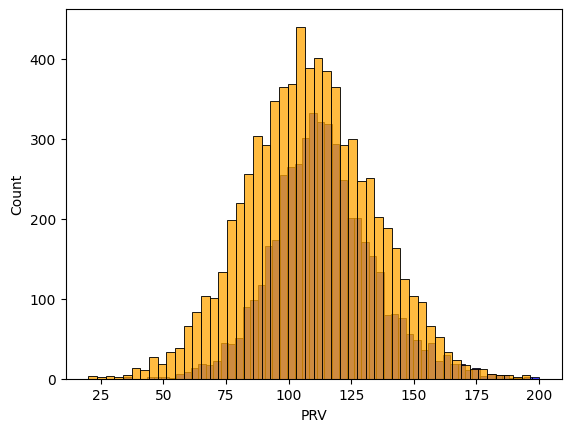

In [259]:
sns.histplot(prv0, color='blue')
sns.histplot(prv1, color='orange')

As we can see, PRV with oximetry typically has higher values.

In [260]:
prv0_out = identify_outliers(prv0)
prv0_out

139      184.398112
212       59.475838
264       58.050890
563      180.151176
585      168.254544
            ...    
11500     60.856255
11513    170.395777
11758     61.300113
11762     56.074730
11938    164.465071
Name: PRV, Length: 123, dtype: float64

In [261]:
prv1_out = identify_outliers(prv1)
prv1_out

204      177.687070
267       30.166640
293       28.075886
993       40.037108
1139     177.878762
2016     176.315121
2375     191.613494
2400      22.287499
3093      35.646940
3130     183.590556
3236     182.313219
3319     191.866240
3539     178.011855
3870     177.051998
3936      22.530095
3992      34.407491
4322      38.843029
4427     188.978761
4455     185.234191
4636      33.944895
5022     182.801684
5216     176.823647
5357      20.000000
5580     182.997721
5624     180.574827
6418      38.955217
6469     194.550528
6881     193.302600
6961      33.913711
7151     186.125513
7331      30.787552
7451     196.472975
7573     186.168046
7741     196.158491
7855     181.238486
7913     176.709219
8060      39.462789
8166     178.430383
8798      27.550637
8864     184.593007
8932      25.551588
9100      37.053579
9581      33.568117
10175    188.318353
10490     39.564626
10650     40.115539
10667    179.023201
10769    178.202427
10900    181.784829
11184     39.248188


In [262]:
prv0 = prv0.drop(prv0_out.index)
prv1 = prv1.drop(prv1_out.index)

<Axes: xlabel='PRV', ylabel='Count'>

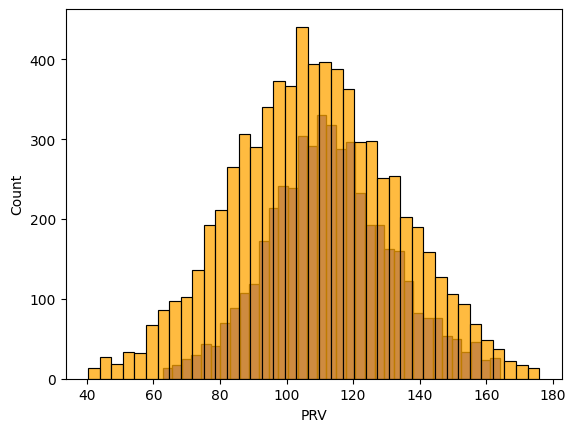

In [263]:
sns.histplot(prv0, color='blue')
sns.histplot(prv1, color='orange')

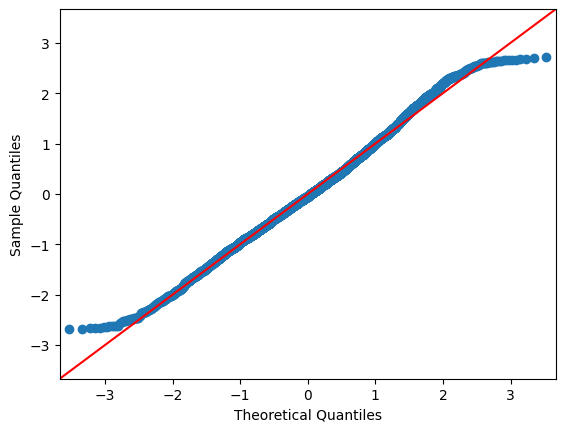

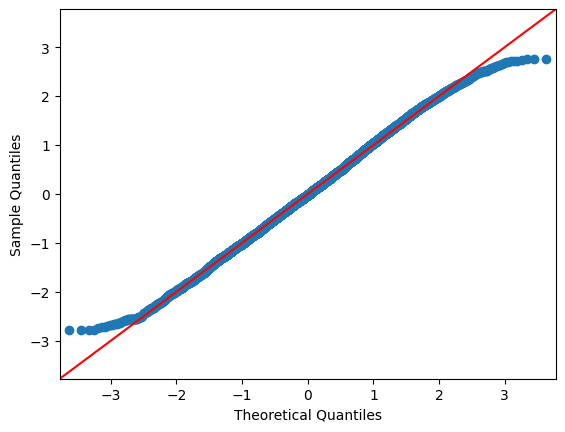

In [264]:
_ = sm.ProbPlot(prv0, fit=True).qqplot(line='45')
_ = sm.ProbPlot(prv1, fit=True).qqplot(line='45')

Visually, they look very similar.

As mentioned earlier, when the number of semples is large, about 5000 and above, Shapiro-Wilk's test may reject the hepothesis. 

In [265]:
stats.shapiro(prv0)

ShapiroResult(statistic=np.float64(0.9957397297975559), pvalue=np.float64(1.4388226307154928e-10))

In [266]:
stats.shapiro(prv1)

c:\Users\Andrii\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7125.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=np.float64(0.9981969700094867), pvalue=np.float64(2.360859459811372e-07))

In this case test reject both of this hepothesis. So the use of this test may not be appropriate in our case. 

**Kolmogorov–Smirnov test** test shows:

In [267]:
stats.kstest(prv0, 'norm', args=(np.mean(prv0), np.std(prv0, ddof=1)))

KstestResult(statistic=np.float64(0.025391493193779202), pvalue=np.float64(0.0041255392407030965), statistic_location=np.float64(120.26340513267094), statistic_sign=np.int8(1))

In [268]:
stats.kstest(prv1, 'norm', args=(np.mean(prv1), np.std(prv1, ddof=1)))

KstestResult(statistic=np.float64(0.010579185130553226), pvalue=np.float64(0.39973461899788876), statistic_location=np.float64(132.60995973371533), statistic_sign=np.int8(-1))

For the group without oximetry normality is rejected. For the group with oximetry is not rejected.  

In [269]:
print(stats.anderson(prv0, dist='norm'))
print(stats.anderson(prv1, dist='norm'))

AndersonResult(statistic=np.float64(4.509574260884619), critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(113.16742853629609), scale=np.float64(18.73718895027454))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=np.float64(1.382250509132973), critical_values=array([0.576, 0.656, 0.787, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(108.25666586261806), scale=np.float64(24.44109678293274))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


We also try **Anderson-Darling** tests, and they shows, that both of our distribution is not normal. We rejected H0 for both groups.

Mann–Whitney U test

In [270]:
stats.mannwhitneyu(prv1, prv0, alternative='greater')

MannwhitneyuResult(statistic=np.float64(14917620.0), pvalue=np.float64(1.0))

In this case, we reject the alternative hypothesis H1. The hypothesis was not confirmed.


In [271]:
stats.mannwhitneyu(prv1, prv0, alternative='less')

MannwhitneyuResult(statistic=np.float64(14917620.0), pvalue=np.float64(5.2311159039525334e-31))

We confirmd that PRV has, on average, a higher value without oximetry than with it.  
The initial hypothesis was not confirmed, but in the course of testing we found that PRV without oximetry was statistically significantly higher than with oximetry.

---

(B-1b) Verify that your statistical tests have sufficient support from the data, i.e., that they have strong enough statistical power.


As discussed above, the size of the dataset adds power to the observations made. 

In [272]:
hb_level0.count(), hb_level1.count()

(np.int64(4788), np.int64(7108))

In [273]:
prv0.count(), prv1.count()

(np.int64(4782), np.int64(7125))

As we can see the average Hb level with oximetry enabled is higher than without it. PRV without oximetry was statistically significantly higher than with oximetry. 

In [274]:
hb_level0.mean() - hb_level1.mean()

np.float64(-1.457975941528149)

In [275]:
prv0.mean() - prv1.mean()

np.float64(4.910762673678022)

The significance level (𝛼) is often set to 5%.

In [276]:
analysis = TTestIndPower()

# Lecture 3 page 69, Cohen's formula 
# In social science: Small effect (0.2), Medium effect (0.5), Large effect (0.8)

hb_level1_mean = hb_level1.mean()
hb_level0_mean = hb_level0.mean()
hb_level1_std = hb_level1.std()
hb_level0_std = hb_level0.std()

hb_level1_len = len(hb_level1)
hb_level0_len = len(hb_level0)

# Cohen's formula, calculated with pooled standard deviation (s) and variance (s2)
s = (hb_level1_mean - hb_level0_mean) / (np.sqrt(((hb_level1_len - 1)*hb_level1_std**2 + (hb_level0_len - 1)*hb_level0_std**2) / (hb_level1_len + hb_level0_len - 2)))

power = analysis.solve_power(
    effect_size=s,
    nobs1=hb_level0_len,
    alpha=0.05,
    ratio=hb_level0_len / hb_level1_len,
    alternative='larger' 
)

print(f"Power of tests with Hb level: {power}")

Power of tests with Hb level: 1.0


The initially proposed hypothesis was rejected during the analysis, after which a new conclusion was drawn. In the following code, we demonstrate that its statistical power is substantial.

In [277]:
prv1_mean = prv1.mean()
prv0_mean = prv0.mean()
prv1_std = prv1.std()
prv0_std = prv0.std()

prv1_len = len(prv1)
prv0_len = len(prv0)

s = (prv1_mean - prv0_mean) / np.sqrt(((prv1_len - 1) * prv1_std**2 + (prv0_len - 1) * prv0_std**2) /(prv1_len + prv0_len - 2))

power = analysis.solve_power(
    effect_size=s,
    nobs1=prv0_len,
    alpha=0.05,
    ratio=prv0_len / prv1_len,
    alternative='smaller'
)

print(f"Power of tests with PRV: {power}")

Power of tests with PRV: 1.0


In the course of this study we have come to the conclusion that the analysis confirms that the applied statistical tests are reliable. We made two hypotheses that showed how the target variable affects Hb level and PRV.